# A Tutorial for Package TFCox(DeepSurv)

## About the Package
`TFCox` is a python package for predicting hazard rate with deep learning method in survival 
analysis. It is developed based on `Tensorflow==1.13.1`. Due to the advent of `Tensorflow2.x`,
which deprecates and reintegrates so many modules and APIs in `Tensorflow1.x` so that greater 
user experience can be achieved, this package is the only version developed by `Tensorflow1.x`. The future version will be developed based on `Tensorflow2.x`. This notebook will show you how to use deep learning in survival analysis.

## Installation
Please follow the instructions on [README](../README.md) to install `TFCox` package.

## Reference
This package implements the model `DeepSurv` in the paper of Katzman et.al. Please refer to 

[1] Katzman, Jared & Shaham, Uri & Cloninger, Alexander & Bates, Jonathan & Jiang, Tingting & 
Kluger, Yuval. (2016). Deep Survival: A Deep Cox Proportional Hazards Network.

[2] Katzman Jared L, Shaham Uri, Cloninger Alexander, Bates Jonathan, Jiang Tingting, Kluger
Yuval. DeepSurv: personalized treatment recommender system using a Cox proportional hazards 
deep neural network.[J]. BMC medical research methodology,2018,18(1).

## A Simulated Example for DeepSurv

### Load necessary modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from TFCox.simulation.tools import load_simulated_data, survival_stats, surv_df
from TFCox.models.deepsurv import DeepSurv

### Prepare a simulated dataset

In [2]:
### Data infos
    # hazard_rate = 2000,
    # number of observations = (5000, 1000),
    # number of features = 10,
    # number of valid features = 2
train_data = load_simulated_data(hr=2000, 
                                 num_features=10, 
                                 num_var=2, 
                                 n_obs=5000,
                                 average_death=500,
                                 seed=0)
test_data = load_simulated_data(hr=2000, 
                                num_features=10, 
                                num_var=2, 
                                n_obs=1000,
                                average_death=100,
                                seed=0)
train_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,T,E
0,0.097627,0.430379,0.205527,0.089766,-0.152690,0.291788,-0.124826,0.783546,0.927326,-0.233117,15.0,0.0
1,0.583450,0.057790,0.136089,0.851193,-0.857928,-0.825741,-0.959563,0.665240,0.556314,0.740024,15.0,0.0
2,0.957237,0.598317,-0.077041,0.561058,-0.763451,0.279842,-0.713293,0.889338,0.043697,-0.170676,15.0,0.0
3,-0.470889,0.548467,-0.087699,0.136868,-0.962420,0.235271,0.224191,0.233868,0.887496,0.363641,15.0,0.0
4,-0.280984,-0.125936,0.395262,-0.879549,0.333533,0.341276,-0.579235,-0.742147,-0.369143,-0.272578,15.0,0.0


### Summary statistics of the dataset

----------Survival Data Statistics----------
# Rows: 5000
# Columns: 10 + T + E
# Events Ratio: 0.9828
# Min Time: 2.9104424e-06
# Max Time: 1.0
--------------------------------------------


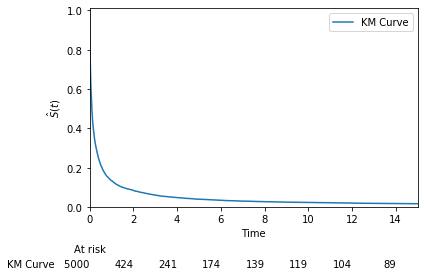

In [3]:
survival_stats(train_data, T_col='T', E_col='E', plot=True)

### Transform the raw data into survival data frame

In [4]:
surv_train = surv_df(train_data, T_col='T', E_col='E', label_col='Y')
surv_test = surv_df(test_data, T_col='T', E_col='E', label_col='Y')
surv_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,E,Y
0,0.097627,0.430379,0.205527,0.089766,-0.152690,0.291788,-0.124826,0.783546,0.927326,-0.233117,0.0,-15.0
1,0.583450,0.057790,0.136089,0.851193,-0.857928,-0.825741,-0.959563,0.665240,0.556314,0.740024,0.0,-15.0
2,0.957237,0.598317,-0.077041,0.561058,-0.763451,0.279842,-0.713293,0.889338,0.043697,-0.170676,0.0,-15.0
3,-0.470889,0.548467,-0.087699,0.136868,-0.962420,0.235271,0.224191,0.233868,0.887496,0.363641,0.0,-15.0
4,-0.280984,-0.125936,0.395262,-0.879549,0.333533,0.341276,-0.579235,-0.742147,-0.369143,-0.272578,0.0,-15.0


### Loss function

The loss function of DeepSurv in package `TFCox` is a little bit different from that referred 
in the paper of Katzman et. al. It is formulated as 
$$l(\theta):= -\sum_{i:E_i=1} (\hat{h}_{\theta}(x_i)- \log \sum_{j \in R(T_i)}e^{\hat{h}_{\theta}(x_j)}) + \lambda _{1}\sum_{i,j}|W_{ij}| + \lambda_2 \sum_{i,j}W_{ij}^2.$$
where $\lambda_1, \lambda_2$ are two regularization coefficients added on the weights in order to avoid overfitting. The item $$-\sum_{i:E_i=1} (\hat{h}_{\theta}(x_i)- \log \sum_{j \in R(T_i)}e^{\hat{h}_{\theta}(x_j)})$$ is the negative partial log likelihood.

### Build a neural network

In [5]:
### There are some warnings because of the incompatiblity, just ignore them.
input_nodes = 11
hidden_layer_nodes = [8, 3, 1]
params = {
    'learning_rate':0.7,
    'learning_rate_decay': 1.0,
    'activation': 'relu',
    'optimizer': 'sgd',
    'L1_reg': 3.4e-5,
    'L2_reg': 8.8e-5,
    'dropout_rate': 0,
    'seed':1
}
net = DeepSurv(
    input_nodes,
    hidden_layer_nodes,
    config=params
)
net.build_graph()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Train the network

Average loss at step 200: 7.5472, metrics at step 200: 0.5405
Average loss at step 400: 7.5015, metrics at step 400: 0.5459
Average loss at step 600: 7.4977, metrics at step 600: 0.5492
Average loss at step 800: 7.4961, metrics at step 800: 0.5497
Average loss at step 1000: 7.4954, metrics at step 1000: 0.5498
Average loss at step 1200: 7.4951, metrics at step 1200: 0.5506
Average loss at step 1400: 7.4949, metrics at step 1400: 0.5506
Average loss at step 1600: 7.4948, metrics at step 1600: 0.5507
Average loss at step 1800: 7.4947, metrics at step 1800: 0.5506
Average loss at step 2000: 7.4946, metrics at step 2000: 0.5510


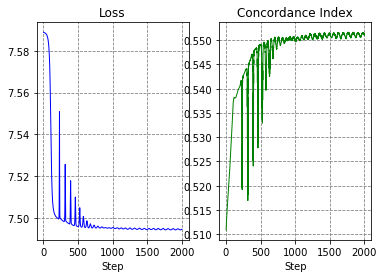

In [6]:
X_cols = [col for col in surv_train.columns if col != 'Y']
wathch_list = net.train(
    surv_train[X_cols],
    pd.DataFrame(surv_train['Y']),
    num_steps=2000,
    batch_size=200,
    plot=True
)

### Model metrics

In [7]:
print('CI metrics on training data:', net.eval(surv_train[X_cols], surv_train['Y']))
print('CI metrics on test data:', net.eval(surv_test[X_cols], surv_test['Y']))

CI metrics on training data: 0.5510251688751676
CI metrics on test data: 0.5398139970801867


### Predictions

#### prediction includes:
 #### 1.prediction on hazard rate or log hazard rate.
 #### 2.prediction on survival function.

In [8]:
print(net.predict(surv_test.loc[0:9, X_cols]))
print(net.predict(surv_test.loc[0:9, X_cols], log=False))

[[0.8929892]
 [7.9685974]
 [1.1099946]
 [7.724752 ]
 [7.9771433]
 [7.9273386]
 [1.0012519]
 [8.251697 ]
 [7.8427205]
 [7.9674163]]
[[2.4424198e+00]
 [2.8888027e+03]
 [3.0343421e+00]
 [2.2636909e+03]
 [2.9135959e+03]
 [2.7720396e+03]
 [2.7216871e+00]
 [3.8341252e+03]
 [2.5471250e+03]
 [2.8853926e+03]]


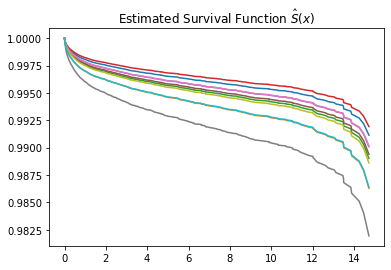

,0.000003,0.000005,0.000006,0.000009,0.000010,0.000018,0.000019,0.000019,0.000022,0.000026,...,13.051814,13.130160,13.463610,13.494261,13.503917,13.847383,13.887574,14.248947,14.469468,14.721280
0,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,...,0.994104,0.993989,0.993859,0.993712,0.993539,0.993329,0.993064,0.992708,0.992171,0.991144
1,1.0,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,0.999997,0.999997,...,0.990864,0.990686,0.990484,0.990257,0.989989,0.989664,0.989254,0.988705,0.987875,0.986288
2,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,0.999998,...,0.992681,0.992538,0.992376,0.992194,0.991979,0.991719,0.991390,0.990949,0.990283,0.989010
3,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,...,0.994625,0.994520,0.994401,0.994267,0.994109,0.993918,0.993676,0.993352,0.992862,0.991925
4,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,...,0.993404,0.993276,0.993129,0.992965,0.992772,0.992537,0.992240,0.991843,0.991243,0.990094
5,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,0.999998,...,0.992935,0.992797,0.992641,0.992465,0.992258,0.992006,0.991689,0.991263,0.990621,0.989391
6,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,...,0.993433,0.993304,0.993159,0.992996,0.992802,0.992569,0.992274,0.991878,0.991280,0.990136
7,1.0,0.999999,0.999999,0.999998,0.999998,0.999998,0.999997,0.999997,0.999997,0.999996,...,0.987951,0.987716,0.987450,0.987151,0.986798,0.986371,0.985831,0.985108,0.984016,0.981929
8,1.0,1.000000,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,0.999998,...,0.992404,0.992256,0.992088,0.991899,0.991676,0.991406,0.991065,0.990607,0.989917,0.988595
9,1.0,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998,0.999997,0.999997,...,0.990919,0.990742,0.990541,0.990315,0.990049,0.989726,0.989319,0.988772,0.987947,0.986370


In [9]:
net.predict_surv_func(surv_train.loc[0:9, X_cols], plot=True)

In [10]:
net.close_session()

Current session closed
